# Computing Energies with Second Calculator
As part of this assignment, our team is using the [ISO17 dataset](http://quantum-machine.org/datasets/) which already has the DFT energies and forces for a bunch of molecules.

Here, we show how to read those structures from ASE and compute a new set of energies

In [1]:
%matplotlib inline
from ase.db import connect
from random import random
from tqdm import tqdm
import pandas as pd
import torchani
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from dscribe.descriptors import CoulombMatrix
from ase.io.xyz import read_xyz
from io import StringIO
import pandas as pd
import numpy as np
import inspect

/home/ketter/anaconda3/envs/applied-ai/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random subset

In [2]:
select_fraction = 0.1  # Get only these many molecules

## Connect to the database
The training data is held in an ASE database, from which we can read out data in the ASE atoms format.

In [3]:
db = connect('iso17/reference.db')
print(f'Connected to a database with {len(db)} entries')
print(db)

Connected to a database with 404000 entries


You can run queries on this database and loop through it

In [4]:
for row in db.select(limit=1):
    continue

Get row contains information about a specific conformation of a molecule, such as its position and energy

In [5]:
row.total_energy

-11504.4727992531

It is often convenient to just combine them into an [Atoms object](https://wiki.fysik.dtu.dk/ase/ase/atoms.html) we can manipulate easily.

In [6]:
atoms = row.toatoms()
atoms

Atoms(symbols='OC3OC4H10', pbc=False)

## Computing new Energies
We can use the Atoms object from each row to compute new properties, such as by using the interatomic potential from TorchANI to generate a different energy.

In [7]:
calc = torchani.models.ANI2x().ase()

/home/ketter/anaconda3/envs/applied-ai/lib/python3.7/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [8]:
new_energy = calc.get_potential_energy(atoms)
print(f'The DFT energy for this geometry is {row.total_energy:.2f} and the ANI energy is {new_energy:.2f}')

The DFT energy for this geometry is -11504.47 and the ANI energy is -11510.37


/home/ketter/anaconda3/envs/applied-ai/lib/python3.7/site-packages/torchani/ase.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  dtype=self.dtype, device=self.device)
/home/ketter/anaconda3/envs/applied-ai/lib/python3.7/site-packages/torchani/aev.py:236: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pair_sizes = counts * (counts - 1) // 2


## Combining it together
Let's make a big array where we store all of energies

In [9]:
data = []
for row in tqdm(db.select(limit=5000), total=db.count()):  # Remove limit if you want to read the whole dataset
    # Skip a certain proportion of the entries
    if random() < select_fraction:
        continue
        
    # For those we don't skip, compute a new energy
    atoms = row.toatoms()
    symbols1=(atoms.symbols)
    ani_energy = calc.get_potential_energy(atoms)
    
    # Save them to a list
    data.append({
        'atoms': atoms,
        'ani_energy': ani_energy,
        'dft_energy': row.total_energy,
        'delta': row.total_energy-ani_energy
    })

  1%|‚ñç                                      | 5000/404000 [01:07<1:30:03, 73.83it/s]


In [10]:
data = pd.DataFrame(data)

Now safe it to disk in Pickle format so that we can read them in later

In [11]:
data.to_pickle('train_data.pkl.gz')  # ".gz" means that Pandas will compress this data for you (it's really nice!)

In [12]:
cm = CoulombMatrix(40, permutation='eigenspectrum')
cm.create(data['atoms'].iloc[0])

array([[ 1.95177827e+02,  7.12553622e+01,  4.94223293e+01,
         3.12276503e+01,  2.52076925e+01,  1.90718651e+01,
         9.26259366e+00,  7.88861659e+00,  5.31435459e+00,
        -8.95064693e-01, -6.39326362e-01, -5.89860254e-01,
        -4.32959212e-01, -4.07083368e-01, -3.83028264e-01,
        -2.57803662e-01, -1.38302353e-01, -8.91365501e-02,
         4.43992261e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [13]:
%%time
cms = cm.create(data['atoms'], n_jobs=2) 

CPU times: user 1.42 s, sys: 391 ms, total: 1.81 s
Wall time: 4.6 s


In [14]:
data['cm'] = cms.tolist()

In [15]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('krr', KernelRidge(kernel='rbf'))
])

In [16]:
gs = GridSearchCV(model,
    {'krr__gamma': np.logspace(-10, -3, 16), 'krr__alpha': np.logspace(-10, -3, 16)},
    cv=10,
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
)

Let's train our data with an rbf kernel using kernel ridge regression.

In [17]:
train_data, test_data = train_test_split(data, train_size=1000, test_size=1000)

In [18]:
%%time
gs.fit(np.vstack(train_data['cm']), train_data['dft_energy']);

CPU times: user 2min 58s, sys: 1min 36s, total: 4min 34s
Wall time: 1min 11s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('krr', KernelRidge(kernel='rbf'))]),
             param_grid={'krr__alpha': array([1.00000000e-10, 2.92864456e-10, 8.57695899e-10, 2.51188643e-09,
       7.35642254e-09, 2.15443469e-08, 6.30957344e-08, 1.84784980e-07,
       5.41169527e-07, 1.58489319e-06, 4.64158883e-06, 1.35935639e-05,
       3.98107171e-05, 1.16591440e-04, 3.41454887e-04, 1.00000000e-03]),
                         'krr__gamma': array([1.00000000e-10, 2.92864456e-10, 8.57695899e-10, 2.51188643e-09,
       7.35642254e-09, 2.15443469e-08, 6.30957344e-08, 1.84784980e-07,
       5.41169527e-07, 1.58489319e-06, 4.64158883e-06, 1.35935639e-05,
       3.98107171e-05, 1.16591440e-04, 3.41454887e-04, 1.00000000e-03])},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'MAE (eV)')

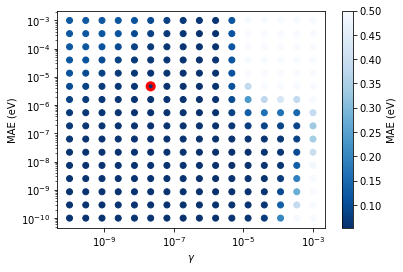

In [19]:
fig, ax = plt.subplots()

# Plot all of the parameters
params = pd.DataFrame(gs.cv_results_['params'])
sd = ax.scatter(params['krr__gamma'], params['krr__alpha'], c=-gs.cv_results_['mean_test_score'],
                vmax=0.5, cmap='Blues_r')
ax.set_xscale('log')
ax.set_yscale('log')

# Mark the best
ax.scatter(gs.best_params_['krr__alpha'], gs.best_params_['krr__gamma'], facecolor='none', edgecolor='red',
           s=50, lw=3)

fig.colorbar(sd, label='MAE (eV)')

ax.set_xlabel('$\gamma$')
ax.set_ylabel('MAE (eV)')

In [20]:
model = gs.best_estimator_

In [21]:
model.fit(np.vstack(train_data['cm']), train_data['dft_energy'])
y_pred = model.predict(np.vstack(test_data['cm']))

Text(0, 0.5, '$Energy$, ML (eV)')

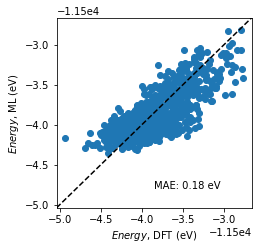

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['dft_energy'], y_pred)

# Make a y=x line
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.text(0.5, 0.1, f'MAE: {mean_absolute_error(y_pred, test_data["dft_energy"]):.2f} eV',
       transform=ax.transAxes)
ax.set_xlabel('$Energy$, DFT (eV)')
ax.set_ylabel('$Energy$, ML (eV)')

Let's use the delta function now.

In [23]:
modeldelta = Pipeline([
    ('scale', StandardScaler()),
    ('krr', KernelRidge(kernel='laplacian'))
])

In [24]:
gs2 = GridSearchCV(modeldelta,
    {'krr__gamma': np.logspace(-6, 2, 16), 'krr__alpha': np.logspace(-6, 2, 16)},
    cv=10,
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
)

In [25]:
%%time
gs2.fit(np.vstack(train_data['cm']), train_data['delta']);

CPU times: user 4min 29s, sys: 2min 46s, total: 7min 15s
Wall time: 1min 52s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('krr',
                                        KernelRidge(kernel='laplacian'))]),
             param_grid={'krr__alpha': array([1.00000000e-06, 3.41454887e-06, 1.16591440e-05, 3.98107171e-05,
       1.35935639e-04, 4.64158883e-04, 1.58489319e-03, 5.41169527e-03,
       1.84784980e-02, 6.30957344e-02, 2.15443469e-01, 7.35642254e-01,
       2.51188643e+00, 8.57695899e+00, 2.92864456e+01, 1.00000000e+02]),
                         'krr__gamma': array([1.00000000e-06, 3.41454887e-06, 1.16591440e-05, 3.98107171e-05,
       1.35935639e-04, 4.64158883e-04, 1.58489319e-03, 5.41169527e-03,
       1.84784980e-02, 6.30957344e-02, 2.15443469e-01, 7.35642254e-01,
       2.51188643e+00, 8.57695899e+00, 2.92864456e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'MAE (eV)')

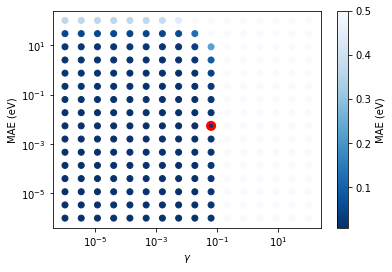

In [26]:
fig, ax = plt.subplots()

# Plot all of the parameters
params = pd.DataFrame(gs2.cv_results_['params'])
sd = ax.scatter(params['krr__gamma'], params['krr__alpha'], c=-gs2.cv_results_['mean_test_score'],
                vmax=0.5, cmap='Blues_r')
ax.set_xscale('log')
ax.set_yscale('log')

# Mark the best
ax.scatter(gs2.best_params_['krr__alpha'], gs2.best_params_['krr__gamma'], facecolor='none', edgecolor='red',
           s=50, lw=3)

fig.colorbar(sd, label='MAE (eV)')

ax.set_xlabel('$\gamma$')
ax.set_ylabel('MAE (eV)')

In [27]:
modeldelta = gs2.best_estimator_

In [28]:
modeldelta.fit(np.vstack(train_data['cm']), train_data['delta'])
y_pred = modeldelta.predict(np.vstack(test_data['cm']))

Text(0, 0.5, '$Energy$, ML Delta (eV)')

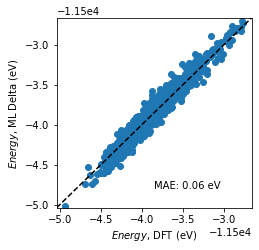

In [29]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['dft_energy'], test_data['ani_energy']+y_pred)
reconstruct=test_data['ani_energy']+y_pred
# Make a y=x line
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.text(0.5, 0.1, f'MAE: {mean_absolute_error(reconstruct, test_data["dft_energy"]):.2f} eV',
       transform=ax.transAxes)
ax.set_xlabel('$Energy$, DFT (eV)')
ax.set_ylabel('$Energy$, ML Delta (eV)')

The delta function has considerably outperformed the KRR with rbf. Let's do one more test just to make sure that the laplacian function doesn't do better than the rbf.

In [30]:
gscontrol = GridSearchCV(modeldelta,
    {'krr__gamma': np.logspace(-10, -3, 16), 'krr__alpha': np.logspace(-10, -3, 16)},
    cv=10,
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
)

In [31]:
%%time
gscontrol.fit(np.vstack(train_data['cm']), train_data['dft_energy']);

CPU times: user 4min 13s, sys: 2min 46s, total: 6min 59s
Wall time: 1min 56s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('krr',
                                        KernelRidge(alpha=0.0630957344480193,
                                                    gamma=0.0054116952654646375,
                                                    kernel='laplacian'))]),
             param_grid={'krr__alpha': array([1.00000000e-10, 2.92864456e-10, 8.57695899e-10, 2.51188643e-09,
       7.35642254e-09, 2.15443469e-08, 6.30957344e-08, 1.84784980e-07,
       5.41169527e-07, 1.58489319e-06, 4...
       3.98107171e-05, 1.16591440e-04, 3.41454887e-04, 1.00000000e-03]),
                         'krr__gamma': array([1.00000000e-10, 2.92864456e-10, 8.57695899e-10, 2.51188643e-09,
       7.35642254e-09, 2.15443469e-08, 6.30957344e-08, 1.84784980e-07,
       5.41169527e-07, 1.58489319e-06, 4.64158883e-06, 1.35935639e-05,
       3.98107171e-05, 1.16591440e-04, 3.41454887e-04, 1.00000000e-03])},
      

Text(0, 0.5, 'MAE (eV)')

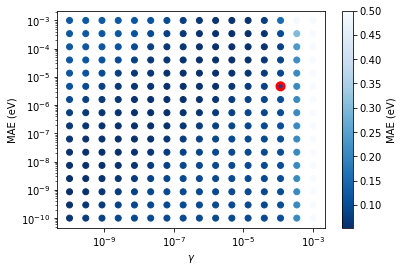

In [32]:
fig, ax = plt.subplots()

# Plot all of the parameters
params = pd.DataFrame(gscontrol.cv_results_['params'])
sd = ax.scatter(params['krr__gamma'], params['krr__alpha'], c=-gscontrol.cv_results_['mean_test_score'],
                vmax=0.5, cmap='Blues_r')
ax.set_xscale('log')
ax.set_yscale('log')

# Mark the best
ax.scatter(gscontrol.best_params_['krr__alpha'], gscontrol.best_params_['krr__gamma'], facecolor='none', edgecolor='red',
           s=50, lw=3)

fig.colorbar(sd, label='MAE (eV)')

ax.set_xlabel('$\gamma$')
ax.set_ylabel('MAE (eV)')

In [33]:
modeldelta = gscontrol.best_estimator_

In [34]:
modeldelta.fit(np.vstack(train_data['cm']), train_data['dft_energy'])
y_pred_control = modeldelta.predict(np.vstack(test_data['cm']))

Text(0, 0.5, '$E_{atom}$, ML (eV)')

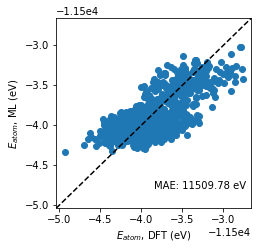

In [35]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['dft_energy'], y_pred_control)

# Make a y=x line
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.text(0.5, 0.1, f'MAE: {mean_absolute_error(y_pred, test_data["dft_energy"]):.2f} eV',
       transform=ax.transAxes)
ax.set_xlabel('$E_{atom}$, DFT (eV)')
ax.set_ylabel('$E_{atom}$, ML (eV)')